Data Processing - Steric Paper - Part 1 

After computing the steric height for each of the datasets, we:
1. Regrid everything to the ETOPO1 132x360 
2. Apply land mask computed based on the ETOPO1 values.
3. Select time periods
    a. 2005-2015
    b. 1993-2017
    
   


In [1]:
import os
import sys
sys.path.append("/Users/ccamargo/Documents/py_scripts/")
import utils_SL as sl 
import xarray as xr
import numpy as np


def get_filelist_sufix(path,  #'/Volumes/ccamargo/Data/'
                 sufix='', #'*grb'
                 sort=True
                 ):
    flist=[filename for filename in os.listdir(path) 
    if filename.endswith(sufix)]
    if sort:
        flist=sorted(flist) # Force it to be in the right order
    
    return flist


import cmocean as cmo
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd

In [2]:
import datetime as dt
from netCDF4 import Dataset
def write_nc(value,lati=[0],long=[0],tempo=[0],dep=[0],dim=3,
             #path='/Users/',fname='file',
             time_un='months since 1993-01-01',
             time_span='from 1993.01 to 2017.12',
             data_name='sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source='source',
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date='made on this date',
             kurs='/Users/ccamargo/Desktop/filename.nc'):

             
    ncfile = Dataset(kurs,'w',format='NETCDF4_CLASSIC')
    
    # create Dimension
    lat_dim = ncfile.createDimension('lat', len(lati)) # latitude axis
    # Create Variable
    lat = ncfile.createVariable('lat', np.float32, ('lat',))
    lat.units = 'degrees_north'
    lat.long_name = 'latitude'
    # Add data to variable
    lat[:] = lati
    
    lon_dim = ncfile.createDimension('lon', len(long)) # latitude axis
    lon = ncfile.createVariable('lon', np.float32, ('lon',))
    lon.units = 'degrees_east'
    lon.long_name = 'longitude'
    lon[:]=long
    
    
    
    time_dim = ncfile.createDimension('time',len(tempo)) # time axis
    time = ncfile.createVariable('time', np.float32, ('time',))
    time.units = time_un
    time.long_name = 'time'
    time[:]=tempo
    
    
    ## 
    s=value.shape
    
    data = ncfile.createVariable('data',np.float64,('time','lat','lon'))
    data[:,:,:]=value
    
    data.units=data_un
    data.standard_name=data_name
    data.depth=data_depth
    data.missing=data_missing
    
    ncfile.metadata=data_metadata
    ncfile.depth_info=depth_info
    ncfile.timespan=time_span
    ncfile.source=data_source
    ncfile.comp_date=comp_date
    
    # close file
    ncfile.close();

# 1. Regridding

In [3]:
# 1. create grid from etopo file
_tmp=os.system('cdo griddes /Users/ccamargo/Desktop/paper1/topo/landmask_nan1_360x132_nc.nc > etopo1_grid')
# etopo was regridded with the topo.py file in the ../topo folder

#2. get filelist
path_to_original_files='/Users/ccamargo/Desktop/paper1/steric/data/original/'
flist=get_filelist_sufix(path_to_original_files,sufix='.nc')

path_to_regrided_files='/Users/ccamargo/Desktop/paper1/steric/data/regrid_132x360/'


# 3. Regrid:
for file in flist:
    fin=path_to_original_files+file
    fout=path_to_regrided_files+file
    command_list=str('cdo remapbil,etopo1_grid '+fin+' '+fout)
    _tmp=os.system(command_list)


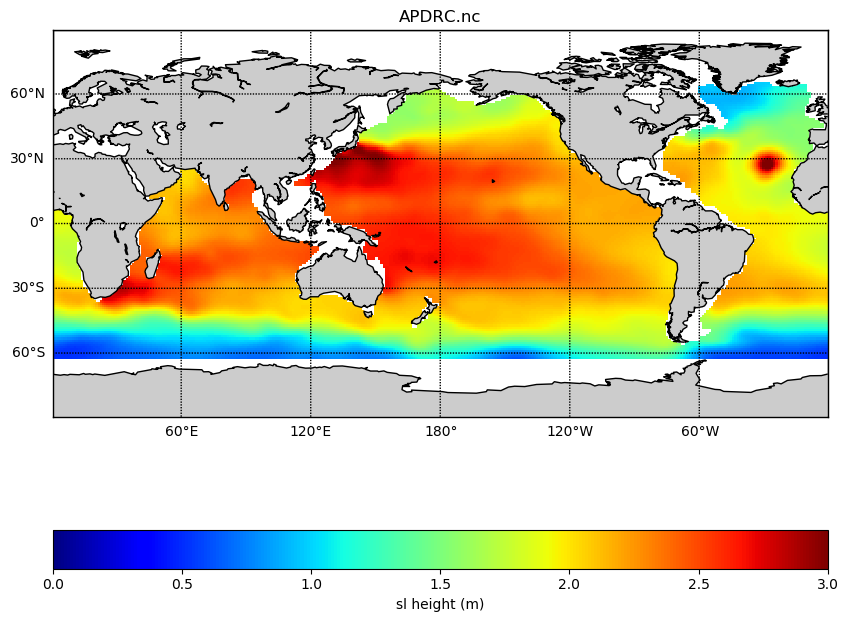

In [4]:
# check if it worked:
file=flist[0]
fin=path_to_original_files+file

ds=xr.open_dataset(fin,decode_times=False)
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[0,:,:])
sl.plot_map(data,lat,lon,title=file)

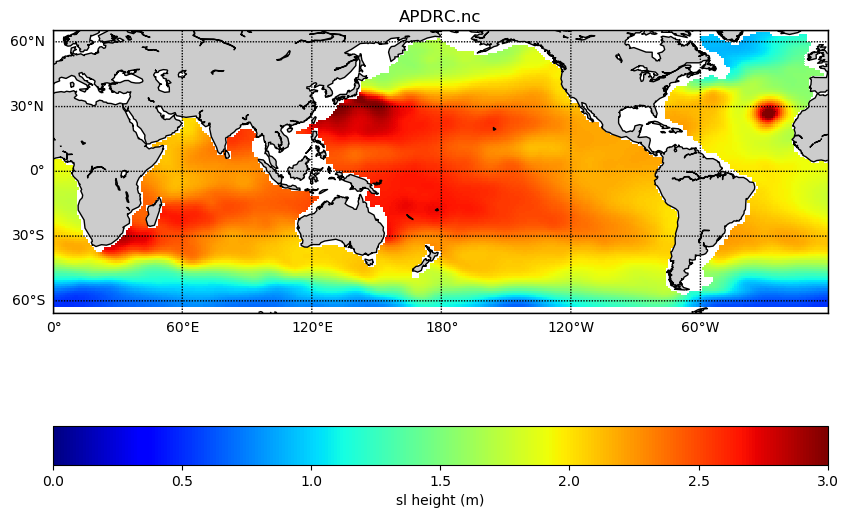

In [5]:
fout=path_to_regrided_files+file
fout
ds=xr.open_dataset(fout,decode_times=False)
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[0,:,:])
sl.plot_map(data,lat,lon,title=file)


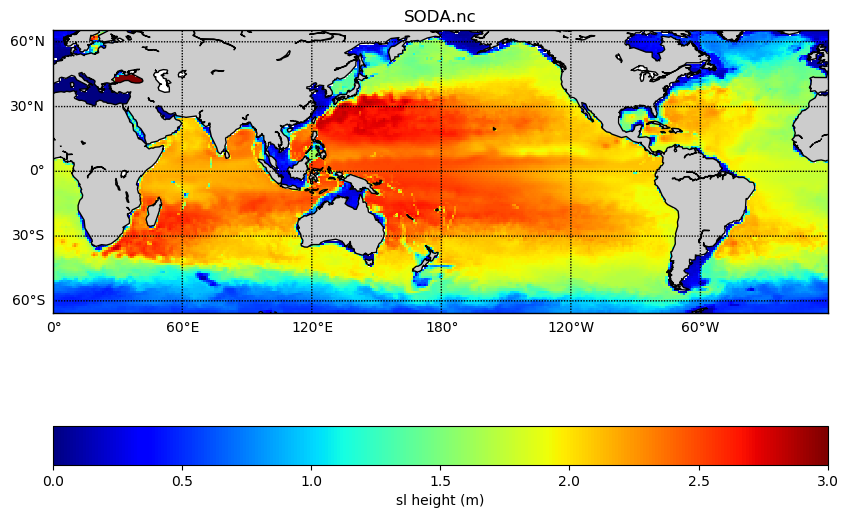

In [6]:
fout=path_to_regrided_files+flist[-1]
ds=xr.open_dataset(fout,decode_times=False)
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[0,:,:])
sl.plot_map(data,lat,lon,title=flist[-1])



# 2. Apply land mask & Select time periods

In [7]:
# 1. Get land mask
da=xr.open_dataset('/Users/ccamargo/Desktop/paper1/topo/landmask_nan1_360x132.nc')
da

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360)
Coordinates:
  * lat      (lat) float64 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    mask     (lat, lon) float64 ...
Attributes:
    name:         Land mask: 1=ocean, nan=land
    description:  Land mask based on the ETOPO1 topography, regrided with cdo...
    source:       ETOPO1 1 Arc-Minute Global Relief Model http://www.ngdc.noa...

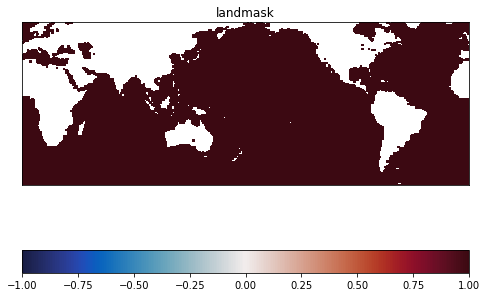

In [8]:
mask=np.array(da.mask)

cmin=-1
cmax=1

#%%
data=mask
fig=plt.figure(figsize=(8,8))
m=Basemap(projection='cyl',
          llcrnrlon=np.min(lon),urcrnrlon=np.max(lon), 
          llcrnrlat=lat.min(),urcrnrlat=lat.max(), 
          resolution='c')

#Plot the field using the fast pcolormesh routine and set the colormap to jet.
m.pcolormesh(lon,lat,data,shading='flat', 
          cmap=cmo.cm.balance)
plt.clim(cmin,cmax)
plt.colorbar(orientation='horizontal')
plt.title('landmask')

plt.show()

## Select time periods

In [9]:
path_to_2005_2015='/Users/ccamargo/Desktop/paper1/steric/data/final/2005-2015/regional/'
path_to_1993_2017='/Users/ccamargo/Desktop/paper1/steric/data/final/1993-2017/regional/'

In [10]:
delt=1296000000000

## APDRC:

In [11]:
file=flist[0]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds


<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 174)
Coordinates:
  * time     (time) float32 0.0 28.0 59.0 89.0 ... 5172.0 5202.0 5233.0 5263.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:03 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       APDRC - http://apdrc.soest.hawaii.edu/projects/Argo/
    metadata:     Monthly gridded surface STERIC fields based on T,S of APDRC...
    depth_info:   27 depth levels, ranging from 0.0 to 2000.0 meters
    timespan:     2005-01-31T00:00:00.000000 to 2019-06-30T00:00:00.000000
    comp_date:    File made on 2020-04-28 18:19:38.901644
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg

In [12]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/2005', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
tim[0]

numpy.datetime64('2005-01-31T00:00:00.000000')

In [13]:
tim[132]

numpy.datetime64('2016-01-31T00:00:00.000000')

In [14]:
t=tim[0:132]
t[-1]

numpy.datetime64('2015-12-31T00:00:00.000000')

In [15]:
i=0
j=132
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])
data=data*mask

fout=path_to_2005_2015+file


write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)


### ArgoRG

In [16]:
file=flist[1]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds



<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 186)
Coordinates:
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 182.0 183.0 184.0 185.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:03 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       http://sio-argo.ucsd.edu/RG_Climatology.html
    metadata:     Monthly gridded surface STERIC fields based on T,S of ArgoR...
    depth_info:   58 depth levels, ranging from 2.5 to 1975.0 meters
    timespan:     2004-01-31T00:00:00.000000 to 2019-06-30T00:00:00.000000
    comp_date:    File made on 2020-04-28 18:19:35.544862
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [17]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/2004', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
tim[12]

numpy.datetime64('2005-01-31T00:00:00.000000')

In [18]:
t=tim[12:144]
t[-1]

numpy.datetime64('2015-12-31T00:00:00.000000')

In [19]:
t[0]

numpy.datetime64('2005-01-31T00:00:00.000000')

In [20]:
i=12
j=144
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])
data=data*mask


fout=path_to_2005_2015+file


write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)



In [21]:
flist[2]

'Armor3D.nc'

In [22]:
file=flist[2]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds



<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 312)
Coordinates:
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 308.0 309.0 310.0 311.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:03 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       ARMOR3D - MULTIOBS_GLO_PHY_REP_015_002 - http://marine.cope...
    metadata:     Monthly gridded surface STERIC fields based on T,S of Armor...
    depth_info:   26 depth levels, ranging from 0 to 2000 meters
    timespan:     1993-01-31T00:00:00.000000 to 2018-12-31T00:00:00.000000
    comp_date:    File made on 2020-04-30 14:39:34.325974
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.

In [23]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/1993', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[0:300]
t[-1]

numpy.datetime64('2017-12-31T00:00:00.000000')

In [24]:
t[0]

numpy.datetime64('1993-01-31T00:00:00.000000')

In [25]:
i=0
j=300
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])
data=data*mask


fout=path_to_1993_2017+file


write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)



In [26]:
t=tim[144:276]
t[0]

numpy.datetime64('2005-01-31T00:00:00.000000')

In [27]:
t[-1]

numpy.datetime64('2015-12-31T00:00:00.000000')

In [28]:
i=144
j=276
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])
data=data*mask


fout=path_to_2005_2015+file


write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)



In [29]:
flist[3]

'BOA.nc'

In [30]:
file=flist[3]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 180)
Coordinates:
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 176.0 177.0 178.0 179.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:05 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       BOA - ftp://data.argo.org.cn/pub/ARGO/BOA_Argo/
    metadata:     Monthly gridded surface STERIC fields based on T,S of BOA, ...
    depth_info:   58 depth levels, ranging from 0.0 to 1975.0 meters
    timespan:     2005-01-31T00:00:00.000000 to 2019-12-31T00:00:00.000000
    comp_date:    File made on 2020-04-28 18:29:19.309324
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [31]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/2005', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[0:132]
t[-1]


numpy.datetime64('2015-12-31T00:00:00.000000')

In [32]:
t[0]

numpy.datetime64('2005-01-31T00:00:00.000000')

In [33]:
i=0
j=132
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])
data=data*mask

fout=path_to_2005_2015+file


write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)

In [34]:
ifile=4
flist[ifile]

'CGlors.nc'

In [35]:
file=flist[ifile]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 300)
Coordinates:
  * time     (time) float32 -2076929800.0 -2076929800.0 ... -2076929800.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:05 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       C-Glors05 from GREPv2 - GLOBAL_REANALYSIS_PHY_001_031  - ht...
    metadata:     Monthly gridded surface STERIC fields based on T,S of CGlor...
    depth_info:   54 depth levels, ranging from 0.50576 to 1945.296 meters
    timespan:     1993-01-31T00:00:00.000000 to 2017-12-31T00:00:00.000000
    comp_date:    File made on 2020-04-29 11:09:45.495865
    CDO:          Climate Data Operators version 1.9.8 (https:/

In [36]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/1993', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[0:300]
t[-1]


numpy.datetime64('2017-12-31T00:00:00.000000')

In [37]:
i=0
j=300
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

fout=path_to_1993_2017+file
#fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)


In [38]:
t=tim[144:276]
t[0]

numpy.datetime64('2005-01-31T00:00:00.000000')

In [39]:
t[-1]

numpy.datetime64('2015-12-31T00:00:00.000000')

In [40]:
i=144
j=276
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

#fout=path_to_1993_2017+file
fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)


In [41]:
flist[5]

'CORA.nc'

In [42]:
file=flist[5]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 342)
Coordinates:
  * time     (time) float32 -2076929800.0 -2076929800.0 ... -2076929800.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:06 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       CORA v5.2 - INSITU_GLO_TS_OA_REP_OBSERVATIONS_013_002_b - h...
    metadata:     Monthly gridded surface STERIC fields based on T,S of CORA,...
    depth_info:   152 depth levels, ranging from 1.0 to 2000.0 meters
    timespan:     1990-01-31T00:00:00.000000 to 2018-06-30T00:00:00.000000
    comp_date:    File made on 2020-04-29 10:27:36.625025
    CDO:          Climate Data Operators version 1.9.8 (https://mpim

In [43]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/1990', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[36:336]
t[0]

numpy.datetime64('1993-01-31T00:00:00.000000')

In [44]:
t[-1]

numpy.datetime64('2017-12-31T00:00:00.000000')

In [45]:
i=36
j=336
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

fout=path_to_1993_2017+file
#fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)


In [46]:
t=tim[180:312]
t[0]

numpy.datetime64('2005-01-31T00:00:00.000000')

In [47]:
t[-1]

numpy.datetime64('2015-12-31T00:00:00.000000')

In [48]:
i=180
j=312
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

#fout=path_to_1993_2017+file
fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)

In [49]:
flist[6]

'Cheng.nc'

In [50]:
file=flist[6]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 354)
Coordinates:
  * time     (time) float32 -2076929800.0 -2076929800.0 ... -2076929800.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:08 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       Cheng - http://ddl.escience.cn/f/FiL0#path=%2F7421275 (link...
    metadata:     Monthly gridded surface STERIC fields based on T,S of Cheng...
    depth_info:   41 depth levels, ranging from 1.0 to 2000.0 meters
    timespan:     1990-01-31T00:00:00.000000 to 2019-06-30T00:00:00.000000
    comp_date:    File made on 2020-04-29 10:00:33.735703
    CDO:          Climate Data Operators version 1.9.8 (https://mpime

In [51]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/1990', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[36:336]
t[0]

numpy.datetime64('1993-01-31T00:00:00.000000')

In [52]:
t[-1]

numpy.datetime64('2017-12-31T00:00:00.000000')

In [53]:
i=36
j=336
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

fout=path_to_1993_2017+file
#fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)



In [54]:
t=tim[180:312]
t[0]

numpy.datetime64('2005-01-31T00:00:00.000000')

In [55]:
t[-1]

numpy.datetime64('2015-12-31T00:00:00.000000')

In [56]:
i=180
j=312
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

#fout=path_to_1993_2017+file
fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)

In [57]:
flist[7]

'EN4.nc'

In [58]:
file=flist[7]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 353)
Coordinates:
  * time     (time) float32 -2076929800.0 -2076929800.0 ... -2076929800.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:08 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       EN.4.2.1 - G10 correction - http://hadobs.metoffice.com/en4...
    metadata:     Monthly gridded surface STERIC fields based on T,S of EN4, ...
    depth_info:   30 depth levels, ranging from 5.0215898 to 1868.0707 meters
    timespan:     1990-01-31T00:00:00.000000 to 2019-05-31T00:00:00.000000
    comp_date:    File made on 2020-04-29 10:50:14.018681
    CDO:          Climate Data Operators version 1.9.8 (http

In [59]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/1990', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[36:336]
t[0]

numpy.datetime64('1993-01-31T00:00:00.000000')

In [60]:
t[-1]

numpy.datetime64('2017-12-31T00:00:00.000000')

In [61]:
i=36
j=336
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

fout=path_to_1993_2017+file
#fout=path_to_2005_2015+file
data=data*mask


write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)



In [62]:
t=tim[180:312]
t[0]

numpy.datetime64('2005-01-31T00:00:00.000000')

In [63]:
t[-1]

numpy.datetime64('2015-12-31T00:00:00.000000')

In [64]:
i=180
j=312
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

#fout=path_to_1993_2017+file
fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)

In [65]:
ifile=8
flist[ifile]


'FOAM.nc'

In [66]:
file=flist[ifile]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 300)
Coordinates:
  * time     (time) float32 -2076929800.0 -2076929800.0 ... -2076929800.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:08 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       FOAM/GloSea5 from GREPv2 - GLOBAL_REANALYSIS_PHY_001_031  -...
    metadata:     Monthly gridded surface STERIC fields based on T,S of FOAM,...
    depth_info:   54 depth levels, ranging from 0.50576 to 1945.296 meters
    timespan:     1993-01-31T00:00:00.000000 to 2017-12-31T00:00:00.000000
    comp_date:    File made on 2020-04-29 11:08:05.577873
    CDO:          Climate Data Operators version 1.9.8 (https:/

In [67]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/1993', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[0:300]
t[-1]

i=0
j=300
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

fout=path_to_1993_2017+file
#fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)

t=tim[144:276]
t[0]

i=144
j=276
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

#fout=path_to_1993_2017+file
fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)


In [68]:
ifile=9
flist[ifile]


'GLORYS.nc'

In [69]:
file=flist[ifile]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 300)
Coordinates:
  * time     (time) float32 -2076929800.0 -2076929800.0 ... -2076929800.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:10 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       GLORYS2V4 from GREPv2 - GLOBAL_REANALYSIS_PHY_001_031  - ht...
    metadata:     Monthly gridded surface STERIC fields based on T,S of GLORY...
    depth_info:   54 depth levels, ranging from 0.50576 to 1945.296 meters
    timespan:     1993-01-31T00:00:00.000000 to 2017-12-31T00:00:00.000000
    comp_date:    File made on 2020-04-29 11:14:46.729575
    CDO:          Climate Data Operators version 1.9.8 (https:/

In [70]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/1993', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[0:300]
t[-1]

i=0
j=300
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

fout=path_to_1993_2017+file
#fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)

t=tim[144:276]
t[0]

i=144
j=276
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

#fout=path_to_1993_2017+file
fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)


In [71]:
ifile=10
flist[ifile]



'ISAS.nc'

In [72]:
file=flist[ifile]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 168)
Coordinates:
  * time     (time) float32 -2076929800.0 -2076929800.0 ... -2076929800.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:12 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       ISAS15_ARGO gridded fields from Argo data only - https://ww...
    metadata:     Monthly gridded surface (10m) STERIC fields based on T,S of...
    depth_info:   152 depth levels, ranging from 1.0 to 2000.0 meters
    timespan:     2002-01-31T00:00:00.000000 to 2015-12-31T00:00:00.000000
    comp_date:    File made on 2020-04-29 11:37:14.378087
    CDO:          Climate Data Operators version 1.9.8 (https://mpim

In [73]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/2002', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[36:168]
t[0]


numpy.datetime64('2005-01-31T00:00:00.000000')

In [74]:
i=36
j=168
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

#fout=path_to_1993_2017+file
fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)

In [75]:
ifile=11
flist[ifile]



'ISASplus-SSS.nc'

In [76]:
file=flist[ifile]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 168)
Coordinates:
  * time     (time) float32 -2076929800.0 -2076929800.0 ... -2076929800.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:12 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       ISAS gridded fields with SSS correction - https://www.seano...
    metadata:     Monthly gridded surface (10m) STERIC fields based on T,S of...
    depth_info:   152 depth levels, ranging from 1.0 to 2000.0 meters
    timespan:     2002-01-31T00:00:00.000000 to 2015-12-31T00:00:00.000000
    comp_date:    File made on 2020-04-29 11:36:12.645559
    CDO:          Climate Data Operators version 1.9.8 (https://mpim

In [77]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/2002', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[36:168]
t[-1]

i=36
j=168
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

#fout=path_to_1993_2017+file
fout=path_to_2005_2015+file
data=data*mask


write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)

In [78]:
ifile=12
flist[ifile]


'Ishii.nc'

In [79]:
file=flist[ifile]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 348)
Coordinates:
  * time     (time) float32 -2076929800.0 -2076929800.0 ... -2076929800.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:13 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       Ishii Dataset v7.2 - https://climate.mri-jma.go.jp/pub/ocea...
    metadata:     Monthly gridded surface (10m) STERIC fields based on T,S of...
    depth_info:   26 depth levels, ranging from 0.0 to 2000.0 meters
    timespan:     1900-01-31T00:00:00.000000 to 1928-12-31T00:00:00.000000
    comp_date:    File made on 2020-04-29 11:52:14.562877
    CDO:          Climate Data Operators version 1.9.8 (https://mpime

In [80]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/1990', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[36:336]
t[-1]

numpy.datetime64('2017-12-31T00:00:00.000000')

In [81]:
t[0]

numpy.datetime64('1993-01-31T00:00:00.000000')

In [82]:
i=36
j=336
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

fout=path_to_1993_2017+file
#fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)


In [83]:
t=tim[180:312]
t[-1]

numpy.datetime64('2015-12-31T00:00:00.000000')

In [84]:
i=180
j=312
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

#fout=path_to_1993_2017+file
fout=path_to_2005_2015+file
data=data*mask


write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)



In [85]:
ifile=13
flist[ifile]

'ORAS.nc'

In [86]:
file=flist[ifile]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 300)
Coordinates:
  * time     (time) float32 -2076929800.0 -2076929800.0 ... -2076929800.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:13 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       ORAS5 from GREPv2 - GLOBAL_REANALYSIS_PHY_001_031  - https:...
    metadata:     Monthly gridded surface STERIC fields based on T,S of ORAS,...
    depth_info:   54 depth levels, ranging from 0.50576 to 1945.296 meters
    timespan:     1993-01-31T00:00:00.000000 to 2017-12-31T00:00:00.000000
    comp_date:    File made on 2020-04-29 11:15:48.344897
    CDO:          Climate Data Operators version 1.9.8 (https:/

In [87]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/1993', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[0:300]
t[-1]

i=0
j=300
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

fout=path_to_1993_2017+file
#fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)

t=tim[144:276]
t[0]

i=144
j=276
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

#fout=path_to_1993_2017+file
fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)


In [88]:
ifile=14
flist[ifile]

'SODA.nc'

In [89]:
file=flist[ifile]
fin=path_to_regrided_files+file

ds=xr.open_dataset(fin,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (lat: 132, lon: 360, time: 336)
Coordinates:
  * time     (time) float32 -2076929800.0 -2076929800.0 ... -2076929800.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 65.5 64.5 63.5 62.5 61.5 ... -62.5 -63.5 -64.5 -65.5
Data variables:
    data     (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri May 01 12:18:15 2020: cdo remapbil,etopo1_grid /Users/c...
    source:       SODA3.3.2 - https://www.atmos.umd.edu/~ocean/index_files/so...
    metadata:     Monthly gridded surface STERIC fields based on PT,S of SODA...
    depth_info:   33 depth levels, ranging from 5.033549785614014 to 1874.788...
    timespan:     1990-01-31T00:00:00.000000 to 2017-12-31T00:00:00.000000
    comp_date:    File made on 2020-04-29 12:05:58.870288
    CDO:          Climate Data Operators version 1.9.8 (h

In [90]:
time=np.array(ds.time)
ty=pd.date_range(start='1/1/1990', periods=len(time),freq='M')
tim = np.array(ty.to_pydatetime(), dtype=np.datetime64)
t=tim[36:336]
t[-1]

numpy.datetime64('2017-12-31T00:00:00.000000')

In [91]:
i=36
j=336
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

fout=path_to_1993_2017+file
#fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=t,dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)


In [92]:
t=tim[180:312]
t[-1]

numpy.datetime64('2015-12-31T00:00:00.000000')

In [93]:
i=180
j=312
lat=np.array(ds.lat)
lon=np.array(ds.lon)
data=np.array(ds.data[i:j,:,:])

#fout=path_to_1993_2017+file
fout=path_to_2005_2015+file

data=data*mask

write_nc(data,lati=lat,long=lon,tempo=np.arange(0,len(t)),dim=3,
             #path='/Users/',fname='file',
             time_un='months since '+str(t[0]-delt),
             time_span='from '+str(t[0])+' to '+str(t[-1]),
             data_name='steric_sea_level_height',data_un='M',
             data_missing='nan',
             data_depth='surface: 0m',
             depth_info='0 to 2000m',
             data_source=str(file),
             data_metadata='Data regridded to 132x360, and applied land mask based on ETOPO1',
             comp_date=str(dt.datetime.now()),
             kurs=fout)


